## Q1) 어떤 task를 선택하셨나요?
> MNLI, 기계 번역

번역에서, 원문과 번역문이 서로 Entailment 관계일 가능성이 높다는 점이 있습다. 때문에 해당 모델을 pre-train 모델로 하여 번역 모델 또한 만들려고 시도하였습다. 하지만 이미지 생성에서 소요되는 시간이 너무나도 길어 아직 번역기는 테스트 중에 있습니다.

번역기 시도 링크 :

https://github.com/raccoonD0G/AIPlus99/blob/main/Homework2_2.ipynb

## Q2) 모델은 어떻게 설계하셨나요? 설계한 모델의 입력과 출력 형태가 어떻게 되나요?
>입력 : 두 문장의 튜플 (premise, hypothesis)

>출력 : 3-class logits

해당 모델은 언어 모델과 이미지 처리 모델을 결합한 형태입니다. 해당 모델에서는 총 3가지의 pre-train 모델이 사용되었습니다. StableDiffusion, DistilBERT, 그리고 직접 제작한 ImageEncoder 입니다.

1. 입력 튜플 속 두 문장은 각각 StableDiffusion 를 통과하며 이미지화 됩니다.
2. 이미지화된 문장은 ImageEncoder 를 통과하며 DistilBERT 의 CLS 토큰과 같은 768 차원으로 변환됩니다.
3. 입력 튜플 속 두 문장은 각각 DistilBERT 를 통과하며 CLS 토큰으로 변환됩니다.
4. ImageEncoder 를 통과한 값과 DistilBERT 를 통과한 값이 서로를 CrossAttantion 한 뒤 이어집니다.
5. 이렇게 이어진 값이 Classifier 를 통과하면서 3-class logits 으로 분류됩니다.

직접 제작한 ImageEncoder 는 CIFAR100 를 통해 학습했습니다.

ImageEncoder 코드 링크 :

https://github.com/raccoonD0G/AIPlus99/blob/main/image_autoencoder.ipynb


## Q3) 실제로 pre-trained 모델을 fine-tuning했을 때 loss curve은 어떻게 그려지나요? 그리고 pre-train 하지 않은 Transformer를 학습했을 때와 어떤 차이가 있나요?

pre-train 하지 않은 모델의 경우 아래와 같은 그래프를 그립니다.
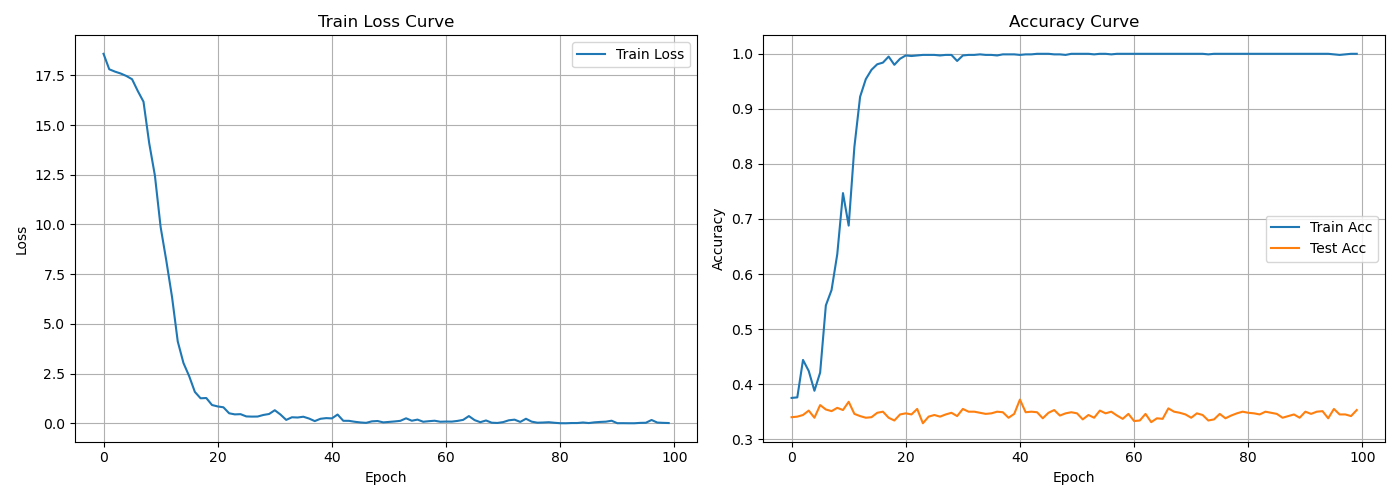

Test 정확도는 33% 내외로, 한 분류로 찍는것과 비슷한 수준을 보여줍니다. 반면 Train 정확도는 100%로 수렴합니다. 이는 심각한 과적화로, Transformer 레이어를 사용했음에도 불구하고 사실상 if-else 식으로 Train 데이터를 암기하고 있습니다. 하지만 여기에 BERT pre-train 을 적용하면 그래프가 아래와 같아집니다.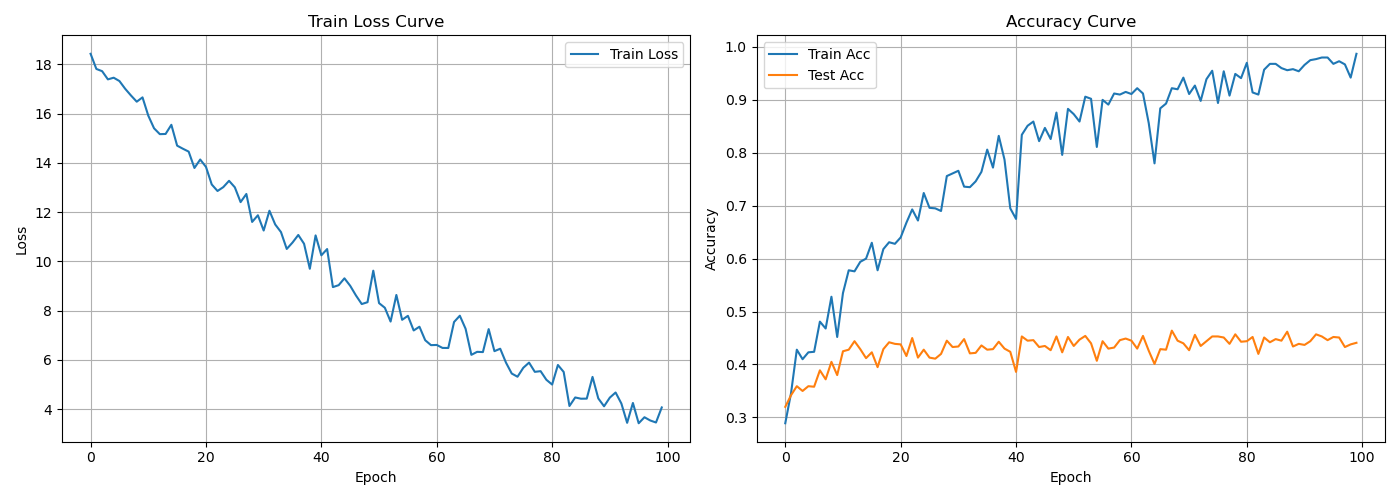

test 정확도가 약 45%로, 어느정도의 분류를 진행하고 있는 것으로 보입니다. 여기서 앞서 설명한 모델처럼, 총 3가지의  pre-train 모델을 사용할 경우 그래프는 아래와 같습니다.
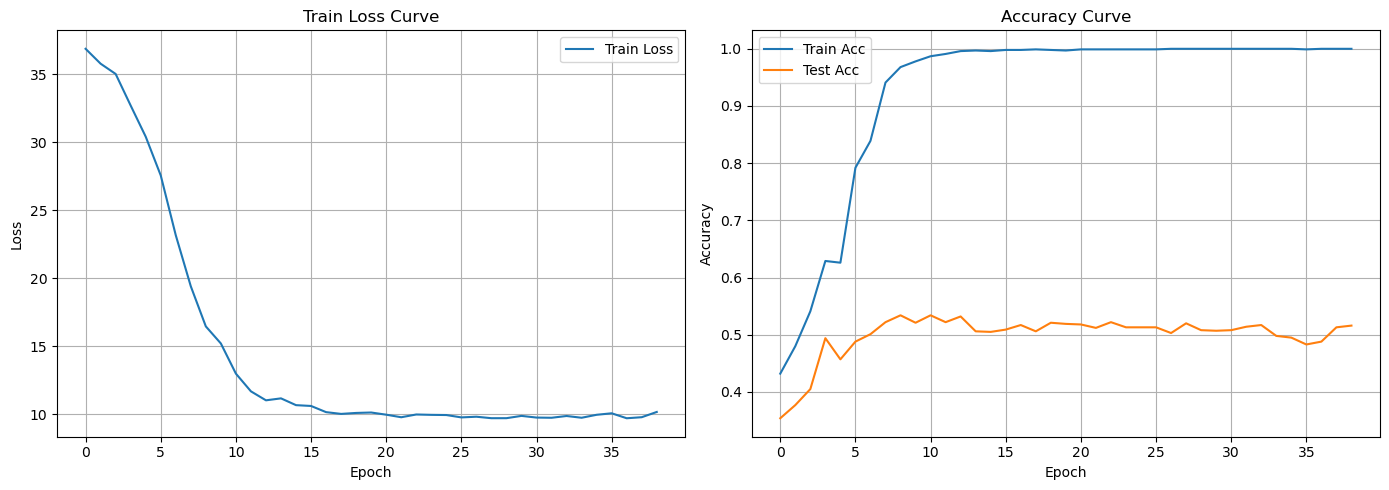

약 10 epoch 에서 약 52% 의 test 정확도를 보여줬습니다. 이미지 생성 모델과 언어 모델을 결합한 것에는 크게 두가지 이유가 있습니다.

첫째는 인간의 사고방식과 흡사하다는 것 입니다. 인간도 언어를 읽음과 동시에 머릿속에서 이미지를 그리며 이해하곤 합니다. 그러한 로직을 모방해보고자 하였습니다.

둘째는 데이터 증강의 용이성입니다. 자연어 처리는 이미지 처리에 비해 데이터 증강(반전, 회전)등이 용이합니다. 자연어의 경우 문자 삭제나 순서 변경 등의 증강법이 존재합니다. 하지만 이런 방식은 어순을 망가트리거나 주요한 단어를 지워버릴 수 있습니다. 때문에 비교적 이미지 증강이 안전한 것으로 알려져 있습니다. 문장과 이미지를 한번에 처리하는 모델이라면, 이미지 쪽에만 증강법을 적용하는 것으로 데이터 양을 크게 늘릴 수 있습니다.

In [ ]:
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
from torchvision import transforms
import kagglehub
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import hashlib
import os
from PIL import Image
from io import BytesIO
from transformers import DistilBertTokenizer, DistilBertModel
from image_autoencoder import ImageEncoder
from tqdm import tqdm

def load_data(path, nrows=None):
    df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
    data = []
    for _, row in df.iterrows():
        if len(row['premise']) * len(row['hypothesis']) != 0:
            data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

    return data

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    premises, hypothesises, labels = [], [], []

    for row in batch:
        premises.append(row['premise'])
        hypothesises.append(row['hypothesis'])
        labels.append(row['label'])

    sentence_pairs = list(zip(premises, hypothesises))

    labels = torch.tensor(labels)

    return sentence_pairs, labels

class CrossAttention(nn.Module):
    def __init__(self, dim=768, heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)

        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, query_feat, context_feat):
        # Cross-Attention
        attn_out, _ = self.attn(query=query_feat, key=context_feat, value=context_feat)
        x = self.ln1(attn_out + query_feat)

        # Feed-Forward Network
        ffn_out = self.ffn(x)
        x = self.ln2(x + ffn_out)
        return x

class TextToImageClassifier(nn.Module):
    def __init__(self, premises=[], hypotheses=[]):
        super().__init__()

        self.image_cache = {}

        if premises and hypotheses:
            self.generate_images_if_needed(premises, hypotheses)
            self.preload_images(premises, hypotheses)
            tqdm.write(f"Preloaded {len(self.image_cache)} images into memory.")

        # BERT tokenizer & 모델
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        for name, param in self.bert.named_parameters():
            if "transformer.layer.4" in name or "transformer.layer.5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Stable Diffusion 모델
        self.pipe = StableDiffusionPipeline.from_pretrained(
            "segmind/tiny-sd",
            torch_dtype=torch.float16,
            safety_checker=None,
            feature_extractor=None
        ).to("cuda")

        self.pipe.enable_attention_slicing()

        # StableDiffusion 을 완전히 얼림, 학습시키지 않을 예정
        for param in self.pipe.unet.parameters():
            param.requires_grad = False

        for param in self.pipe.vae.parameters():
            param.requires_grad = False

        for param in self.pipe.text_encoder.parameters():
            param.requires_grad = False

        # 이미지 전처리 (train용, test용)
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomChoice([
                transforms.RandomRotation(degrees=10),
                transforms.RandomHorizontalFlip(p=1.0),
                transforms.Lambda(lambda x: x)
            ]),
            transforms.ToTensor(),
        ])

        self.eval_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.image_encoder = ImageEncoder().to("cuda")

        self.ln_image = nn.LayerNorm(768)
        self.ln_text = nn.LayerNorm(768)

        self.cross_attn_ti = CrossAttention()  # Text ← Image
        self.cross_attn_it = CrossAttention()  # Image ← Text

        # 결합 후 분류기 (이미지 + 텍스트)
        self.classifier = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 3)
        )

        # 가중치 로드 추가
        save_path = "text_classifier.pt"
        if os.path.exists(save_path):
            self.load_state_dict(torch.load(save_path, map_location="cuda"))
            tqdm.write(f"가중치 로드 완료: {save_path}")
        else:
            tqdm.write(f"저장된 가중치가 없어 처음부터 학습합니다.")

    # 이미지 파일 경로 반환
    def prompt_to_image_filename(self, premise, hypothesis):
        hash_key = hashlib.md5((premise + hypothesis).encode()).hexdigest()
        return os.path.join("image_save", f"{hash_key}.png")

    def load_image(self, path):
        with open(path, "rb") as f:
            img_bytes = f.read()
        img = Image.open(BytesIO(img_bytes))
        return img.convert("RGB") if img.mode != "RGB" else img

    def load_image_cached(self, path):
        if path in self.image_cache:
            return self.image_cache[path]
        img = self.load_image(path)
        self.image_cache[path] = img
        return img

    def preload_images(self, premises, hypotheses):
        for prem, hypo in zip(premises, hypotheses):
            path = self.prompt_to_image_filename(prem, hypo)
            if os.path.exists(path):
                self.image_cache[path] = self.load_image(path)

    def generate_images_if_needed(self, premises, hypotheses, batch_size=8):
        need_generate = []
        for prem, hypo in zip(premises, hypotheses):
            path = self.prompt_to_image_filename(prem, hypo)
            if not os.path.exists(path):
                need_generate.append((prem, hypo))

        if not need_generate:
            return

        for i in range(0, len(need_generate), batch_size):
            batch = need_generate[i:i + batch_size]
            p_prompts = [p for p, _ in batch]
            h_prompts = [h for _, h in batch]

            with torch.no_grad():
                p_imgs = self.pipe(p_prompts, num_inference_steps=10, progress_bar=False).images
                h_imgs = self.pipe(h_prompts, num_inference_steps=10, progress_bar=False).images

            for (prem, hypo), p_img, h_img in zip(batch, p_imgs, h_imgs):
                combined = Image.new("RGB", (p_img.width + h_img.width, p_img.height))
                combined.paste(p_img, (0, 0))
                combined.paste(h_img, (p_img.width, 0))
                combined.save(self.prompt_to_image_filename(prem, hypo))

    def forward(self, sentence_pairs):
        images, texts = [], []

        # 문장 분리
        premises = [p for p, _ in sentence_pairs]
        hypotheses = [h for _, h in sentence_pairs]

        # 1. 이미지 경로 생성 및 이미지 필요 시 생성
        img_paths = [self.prompt_to_image_filename(p, h) for p, h in sentence_pairs]
        self.generate_images_if_needed(premises, hypotheses)

        # 2. 이미지 로드 및 텍스트 인코딩
        for (premise, hypothesis), img_path in zip(sentence_pairs, img_paths):
            combined_text = f"{premise} [SEP] {hypothesis}"
            combined = self.load_image_cached(img_path)

            if combined.mode != "RGB":
                combined = combined.convert("RGB")

            w = combined.width // 2
            p_img = combined.crop((0, 0, w, combined.height))
            h_img = combined.crop((w, 0, combined.width, combined.height))

            combo = Image.new("RGB", (p_img.width + h_img.width, p_img.height))
            combo.paste(p_img, (0, 0))
            combo.paste(h_img, (p_img.width, 0))

            transform = self.train_transform if self.training else self.eval_transform
            images.append(transform(combo))
            texts.append(combined_text)

        # 3. Encoder + BERT + Classifier
        images = torch.stack(images).to("cuda")  # (B, 3, 224, 224)
        img_features = self.image_encoder(images)

        encoded = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to("cuda")
        bert_outputs = self.bert(**encoded).last_hidden_state[:, 0, :]  # (B, 768)

        img_features = self.ln_image(img_features)
        bert_outputs = self.ln_text(bert_outputs)

        # BERT + ImageEncoder 결과
        text_feat = bert_outputs.unsqueeze(1)  # (B, 1, 768)
        image_feat = img_features.unsqueeze(1)  # (B, 1, 768)

        # Cross Attention 각각 적용
        fused_text = self.cross_attn_ti(text_feat, image_feat)  # Text <- Image
        fused_img = self.cross_attn_it(image_feat, text_feat)  # Image <- Text

        # flatten 후 concat
        fused = torch.cat([fused_text.squeeze(1), fused_img.squeeze(1)], dim=-1)  # (B, 1536)

        return self.classifier(fused)

    def extract_features(self, sentence_pairs):
        images, texts = [], []

        # 문장 분리
        premises = [p for p, _ in sentence_pairs]
        hypotheses = [h for _, h in sentence_pairs]

        # 이미지 경로 및 생성
        img_paths = [self.prompt_to_image_filename(p, h) for p, h in sentence_pairs]
        self.generate_images_if_needed(premises, hypotheses)

        for (premise, hypothesis), img_path in zip(sentence_pairs, img_paths):
            combined_text = f"{premise} [SEP] {hypothesis}"
            combined = self.load_image_cached(img_path)

            if combined.mode != "RGB":
                combined = combined.convert("RGB")

            w = combined.width // 2
            p_img = combined.crop((0, 0, w, combined.height))
            h_img = combined.crop((w, 0, combined.width, combined.height))

            combo = Image.new("RGB", (p_img.width + h_img.width, p_img.height))
            combo.paste(p_img, (0, 0))
            combo.paste(h_img, (p_img.width, 0))

            transform = self.train_transform if self.training else self.eval_transform
            images.append(transform(combo))
            texts.append(combined_text)

        # 인코딩
        images = torch.stack(images).to("cuda")
        img_features = self.image_encoder(images)

        encoded = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to("cuda")
        bert_outputs = self.bert(**encoded).last_hidden_state[:, 0, :]

        img_features = self.ln_image(img_features)
        bert_outputs = self.ln_text(bert_outputs)

        text_feat = bert_outputs.unsqueeze(1)
        image_feat = img_features.unsqueeze(1)

        fused_text = self.cross_attn_ti(text_feat, image_feat)
        fused_img = self.cross_attn_it(image_feat, text_feat)

        fused = torch.cat([fused_text.squeeze(1), fused_img.squeeze(1)], dim=-1)  # (B, 1536)
        return fused


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()

    for data in dataloader:
        sentence_pairs, labels = data
        labels = labels.to('cuda')

        preds = model(sentence_pairs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.size(0)
        acc += (preds == labels).sum().item()

    return acc / cnt

In [ ]:
if __name__ == "__main__":
    path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")
    tqdm.write("Path to dataset files:" + path)

    # 데이터가 부족한 상황을 가정하여 1000개만 로드
    train_ds = load_data(path + '/train.csv', nrows=1000)
    test_ds = load_data(path + '/validation_matched.csv', nrows=1000)

    # 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
    train_loader = DataLoader(
        train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn
    )

    # 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
    test_loader = DataLoader(
        test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn
    )

    model = TextToImageClassifier().to("cuda")

    # 학습 설정
    lr = 5e-5
    # 과한 확신을 막기 위한 Label Smoothing
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = Adam(model.parameters(), lr=lr)
    n_epochs = 100

    # 정확도 및 손실 기록용 리스트
    train_losses = []
    train_accuracies = []
    test_accuracies = []


Path to dataset files:C:\Users\admin\.cache\kagglehub\datasets\thedevastator\unlocking-language-understanding-with-the-multin\versions\2


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
    # 학습 루프
    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            model.zero_grad()

            sentence_pairs, labels = data
            labels = labels.to('cuda').long()

            preds = model(sentence_pairs)
            loss = loss_fn(preds, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 손실 기록
        train_losses.append(total_loss)
        tqdm.write(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f}")

        save_path = "text_classifier.pt"
        torch.save(model.state_dict(), save_path)
        tqdm.write(f"모델 가중치 저장 완료: {save_path}")

        # 평가
        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)

            tqdm.write(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            if epoch % 5 == 0:
                tqdm.write("\n샘플 예측 결과 (무작위 5개):\n")
                model.eval()

                random_samples = random.sample(test_ds, 5)  # 20개 무작위 샘플 추출
                sentence_pairs, labels = collate_fn(random_samples)
                labels = labels.to('cuda')
                preds = model(sentence_pairs)
                preds = torch.argmax(preds, dim=-1)

                for i in range(len(sentence_pairs)):
                    prem, hypo = sentence_pairs[i]
                    true_label = labels[i].item()
                    pred_label = preds[i].item()

                    tqdm.write(f"Premise   : {prem}")
                    tqdm.write(f"Hypothesis: {hypo}")
                    tqdm.write(f"Label: {true_label} | Predicted: {pred_label}")
                    tqdm.write("-" * 80)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [01:15<00:00,  2.35s/it]


Epoch   0 | Train Loss: 36.8527
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.432 | Test acc: 0.354

샘플 예측 결과 (무작위 5개):

Premise   : You have to walk through it).
Hypothesis: You need to pass through it on foot.
Label: 0 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : yep that's what he's worried about the trees or a bush because lilac bushes they they grow fast some people uh would really like to have them and then the people that do have them they spread and they sprout all over their their lawn
Hypothesis: The lilac bushes grow so fast and latch onto everything around them, so they could prevent the trees from getting water.
Label: 1 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : The island has a long history; its marble deposits were coveted around the ancient world.
Hypothesis: In 2000 B.C.E the marble was highly desirable.
Label: 1 | Predicted: 2
---

Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.75s/it]


Epoch   1 | Train Loss: 35.7585
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.480 | Test acc: 0.377


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.78s/it]


Epoch   2 | Train Loss: 35.0048
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.541 | Test acc: 0.405


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.72s/it]


Epoch   3 | Train Loss: 32.6812
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.629 | Test acc: 0.494


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.75s/it]


Epoch   4 | Train Loss: 30.3954
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.626 | Test acc: 0.457


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.74s/it]


Epoch   5 | Train Loss: 27.5471
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.792 | Test acc: 0.488

샘플 예측 결과 (무작위 5개):

Premise   : As discussed in section 1, personal saving is the amount of aggregate disposable personal income left over after personal spending on goods and services.
Hypothesis: Personal saving is how much disposable personal income is left over after personal spending and is typically about 5%.
Label: 1 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : The Leland Act  (1) simplify the household definition
Hypothesis: The Leland Act defines the legal definition of what a household is.
Label: 1 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : Clean shaven, I think and dark."
Hypothesis: I think that person was dark and shaven clean.
Label: 0 | Predicted: 0
--------------------------------------------------------------------------------
Premis

Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.80s/it]


Epoch   6 | Train Loss: 23.1536
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.839 | Test acc: 0.501


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch   7 | Train Loss: 19.4004
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.941 | Test acc: 0.522


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.73s/it]


Epoch   8 | Train Loss: 16.4521
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.968 | Test acc: 0.534


Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch   9 | Train Loss: 15.1981
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.978 | Test acc: 0.521


Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.77s/it]


Epoch  10 | Train Loss: 12.9820
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.987 | Test acc: 0.534

샘플 예측 결과 (무작위 5개):

Premise   : Additionally, GAO's FederalInformationSystemControlsAuditManualis now used by most major federal audit entities to evaluate computerrelated controls.
Hypothesis: GAO's system is ranked the best by most federal audit entities.
Label: 1 | Predicted: 1
--------------------------------------------------------------------------------
Premise   : This popular show spawned the aquatic show at the Bellagio.
Hypothesis: This popular show is unrelated to the origins of Bellogio's water display.
Label: 2 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : IDPA's OIG's mission is to prevent, detect, and eliminate fraud, waste, abuse, and misconduct in various payment programs.
Hypothesis: IDPA's OIG's mission took 3 days to be written.
Label: 1 | Predicted: 1
------------------------------------------

Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.76s/it]


Epoch  11 | Train Loss: 11.6808
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.991 | Test acc: 0.522


Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:58<00:00,  1.82s/it]


Epoch  12 | Train Loss: 11.0205
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.996 | Test acc: 0.532


Epoch 14/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.73s/it]


Epoch  13 | Train Loss: 11.1645
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.997 | Test acc: 0.506


Epoch 15/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.74s/it]


Epoch  14 | Train Loss: 10.6658
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.996 | Test acc: 0.505


Epoch 16/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.77s/it]


Epoch  15 | Train Loss: 10.6060
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.998 | Test acc: 0.509

샘플 예측 결과 (무작위 5개):

Premise   : There is very little to see here, or at the ruined Essene monastery of Qumran itself.
Hypothesis: There are plenty of interesting sights and experiences here.
Label: 2 | Predicted: 1
--------------------------------------------------------------------------------
Premise   : Sir James's presence in Manchester was not accidental.
Hypothesis: Manchester was not the place that Sir James had intended to go.
Label: 2 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : well what station plays uh that type of music
Hypothesis: Which radio station plays a lot of contemporary Christian music?
Label: 1 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : Once they know their Social Security benefits promised under current law, workers can calcul

Epoch 17/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.78s/it]


Epoch  16 | Train Loss: 10.1525
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.998 | Test acc: 0.517


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.77s/it]


Epoch  17 | Train Loss: 10.0226
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.506


Epoch 19/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:58<00:00,  1.83s/it]


Epoch  18 | Train Loss: 10.0933
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.998 | Test acc: 0.521


Epoch 20/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.81s/it]


Epoch  19 | Train Loss: 10.1250
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.997 | Test acc: 0.519


Epoch 21/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.75s/it]


Epoch  20 | Train Loss: 9.9649
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.518

샘플 예측 결과 (무작위 5개):

Premise   : and uh you know once you start up at the top and try to get those dollars on down to the hands that need them you know there's a lot of places the money stops and disappears along the way
Hypothesis: There needs to be a more transparent distribution of money.
Label: 1 | Predicted: 1
--------------------------------------------------------------------------------
Premise   : Even the most aged and infirm travel here to die, for nothing is more blessed for a devout Hindu than to die in the great waters of the Varanasi and thus be released from the eternal cycle of rebirth.
Hypothesis: There is nothing special to Hindus about the water of the Varanasi.
Label: 2 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : He was of two minds, one reveled in the peace of this village.
Hypothesis: He love

Epoch 22/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:59<00:00,  1.85s/it]


Epoch  21 | Train Loss: 9.7771
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.512


Epoch 23/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.80s/it]


Epoch  22 | Train Loss: 9.9795
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.522


Epoch 24/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.80s/it]


Epoch  23 | Train Loss: 9.9530
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.513


Epoch 25/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:58<00:00,  1.82s/it]


Epoch  24 | Train Loss: 9.9397
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.513


Epoch 26/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:56<00:00,  1.77s/it]


Epoch  25 | Train Loss: 9.7657
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.513

샘플 예측 결과 (무작위 5개):

Premise   : So, which one of you ladies wants to go first.
Hypothesis: There is a question of who should go first.
Label: 0 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : 2. Receiving Water Samples
Hypothesis: The water samples are received by the lab.
Label: 1 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : uh-huh uh-huh uh-huh yeah well that's really neat
Hypothesis: That's cool.
Label: 0 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : On the west side of the square is Old King's House (built in 1762), which was the official residence of the British governor; it was here that the proclamation of emancipation was issued in 1838.
Hypothesis: On the west end of the square is the O

Epoch 27/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:58<00:00,  1.83s/it]


Epoch  26 | Train Loss: 9.8152
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.503


Epoch 28/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch  27 | Train Loss: 9.7074
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.520


Epoch 29/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [01:00<00:00,  1.89s/it]


Epoch  28 | Train Loss: 9.7085
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.508


Epoch 30/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch  29 | Train Loss: 9.8769
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.507


Epoch 31/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:59<00:00,  1.87s/it]


Epoch  30 | Train Loss: 9.7538
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.508

샘플 예측 결과 (무작위 5개):

Premise   : um i've visited the Wyoming area i'm not sure exactly where Dances with Wolves was filmed
Hypothesis: I've only visited the area in the spring.
Label: 1 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : He watched the river flow.
Hypothesis: The river levels were rising.
Label: 1 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : The Data Warehousing Institute provides education and training in the data warehousing and business intelligence industry.
Hypothesis: Business intelligence industry is a new and promising field of study.
Label: 1 | Predicted: 1
--------------------------------------------------------------------------------
Premise   : huh-uh i don't even want to go anywhere yeah that's about it
Hypothesis: There is nowher

Epoch 32/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:52<00:00,  1.65s/it]


Epoch  31 | Train Loss: 9.7389
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.514


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.78s/it]


Epoch  32 | Train Loss: 9.8690
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.517


Epoch 34/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch  33 | Train Loss: 9.7401
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.498


Epoch 35/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.78s/it]


Epoch  34 | Train Loss: 9.9575
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.495


Epoch 36/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.73s/it]


Epoch  35 | Train Loss: 10.0677
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 0.999 | Test acc: 0.483

샘플 예측 결과 (무작위 5개):

Premise   : The public health official's version of the line, Take my wife, please, is Tell Americans to eat kale five times a week.
Hypothesis: Public health authorities believe that people should eat kale many times a week.
Label: 0 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : And, could it not result in a decline in Postal Service volumes across--the--board?
Hypothesis: Nothing will affect Postal Service volumes across--the--board.
Label: 2 | Predicted: 2
--------------------------------------------------------------------------------
Premise   : Then he is very sure. 
Hypothesis: He is very sure of himself.
Label: 1 | Predicted: 0
--------------------------------------------------------------------------------
Premise   : Well? cried Tommy eagerly.
Hypothesis: Tommy didn't speak.
Label: 2 |

Epoch 37/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:54<00:00,  1.72s/it]


Epoch  36 | Train Loss: 9.7033
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.488


Epoch 38/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:57<00:00,  1.79s/it]


Epoch  37 | Train Loss: 9.7799
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.513


Epoch 39/100: 100%|████████████████████████████████████████████████████████████████████| 32/32 [00:55<00:00,  1.73s/it]


Epoch  38 | Train Loss: 10.1657
모델 가중치 저장 완료: text_classifier.pt
=========> Train acc: 1.000 | Test acc: 0.516


Epoch 40/100:  12%|████████▋                                                            | 4/32 [00:07<00:50,  1.80s/it]


KeyboardInterrupt: 

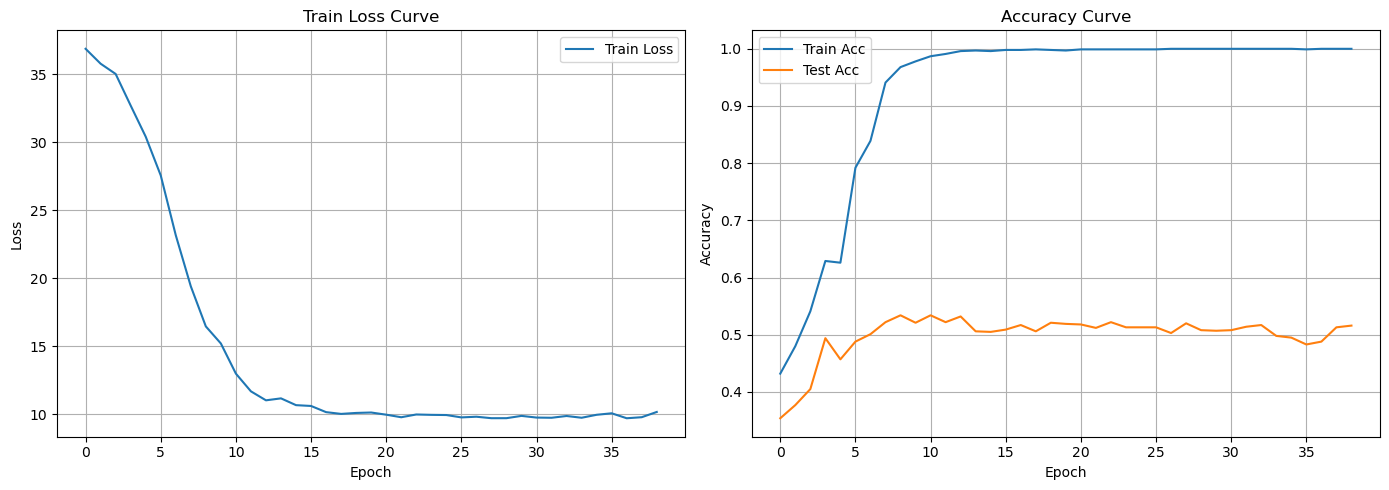

In [ ]:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Train Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(test_accuracies, label="Test Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()